In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [5]:
cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [6]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
from tensorflow import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate,Reshape,BatchNormalization
from keras.models import Sequential, Model
from keras.utils import np_utils
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt
from statistics import mean 

In [7]:
# Load data
images_dir = os.listdir("./flickr_data/Flickr_Data/")

images_path = './flickr_data/Flickr_Data/Images/'
captions_path = './flickr_data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
train_path = './flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
val_path = './flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
test_path = './flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [10]:
# Loading captions as values and images as key in dictionary
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

In [11]:
# Creating train, test and validation dictionaries with key as 'image_id' and values as 'captions'
train_dataset = {}
val_dataset = {}
test_dataset = {}

In [12]:
# Populating the above created dictionaries for train, test and validation dataset with image ids and captions for each of these images
for img in x_train:
    tmp = []
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "startseq " + capt + " endseq"
        tmp.append(caption)
        train_dataset[img] = tmp

for img in x_test:
    tmp = []
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "startseq " + capt + " endseq"
        tmp.append(caption)
        test_dataset[img] = tmp

for img in x_val:
    tmp = []
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "startseq " + capt + " endseq"
        tmp.append(caption)
        val_dataset[img] = tmp

In [13]:
model = InceptionV3(include_top=False,weights='imagenet',input_shape=(299,299,3),pooling='max')
model.summary()

87916544/87910968 [==============================] - 2s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

In [48]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [49]:
# Helper function to process images
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(299,299,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    im = preprocess_input(im) # normalizing the images
    return im

In [16]:
num_of_images = 6000

# train_data = {}

# ctr=0
# for ix in x_train:
#     if ix == "":
#         continue
#     if ctr >= num_of_images:
#         break
#     ctr+=1
#     if ctr%100==0:
#         print(ctr)
#     path = images_path + ix
#     img = preprocessing(path)
#     pred = model.predict(img).reshape(2048)
#     train_data[ix] = pred

# with open( "train" + str(int(num_of_images / 500)) + "_encoded_images.p", "wb" ) as pickle_f:
#   pickle.dump(train_data, pickle_f )

In [17]:
# Storing all the captions from ds into a list
sentences = []

for img in train_dataset.keys():
    for captions in train_dataset[img]:
      sentences.append(captions)

print(len(sentences))

30000


In [18]:
padding_type='pre'
oov_tok = "<OOV>"

In [19]:
ds = []

for img in list(train_dataset.keys())[:num_of_images]:
  for caption in train_dataset[img]:
    ds.append([img, caption])

ds = np.array(ds)

ds.shape

(30000, 2)

In [20]:
training_sentences = []

for caption in ds:
  training_sentences.append(caption[1])

len(training_sentences)

30000

In [21]:
import tensorflow.keras.utils as ku 

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
padded_sequences = []
for line in training_sentences:
  token_list = tokenizer.texts_to_sequences([line])[0]
  tmp = []
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequences.append(n_gram_sequence)
    tmp.append(np.array(n_gram_sequence))
  padded_sequences.append(tmp)
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding=padding_type)) 

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

In [22]:
for seq,i in zip(padded_sequences, range(len(padded_sequences))):
  seq = np.array(pad_sequences(seq, maxlen=max_sequence_len, padding=padding_type))
  padded_sequences[i] = seq

padded_sequences = np.array(padded_sequences)
padded_sequences.shape

(30000,)

In [23]:
input_sequences = []
tmp = []

In [24]:
vocab_size = total_words
next_words = label
caption = predictors

In [25]:
with open('./train' + str(int(num_of_images / 500)) + '_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f, encoding="bytes")

In [26]:
imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0] in encoded_images.keys():
#         print(ix, encoded_images[ds[ix, 0].encode()])
        imgs.append(list(encoded_images[ds[ix, 0]]))

imgs = np.asarray(imgs)
print(imgs.shape)

(30000, 2048)


In [27]:
images = []

for ix in range(imgs.shape[0]):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)
print(images.shape)

(354424, 2048)


In [28]:
print(caption.shape,' | ',next_words.shape,' | ',images.shape)

(354424, 38)  |  (354424,)  |  (354424, 2048)


**Model**

In [29]:
embedding_size = 300
max_len = max_sequence_len

In [30]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len-1))

image_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               614700    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 38, 300)           0         
Total params: 614,700
Trainable params: 614,700
Non-trainable params: 0
_________________________________________________________________


In [31]:
inputs = Input(shape=(max_sequence_len-1,))
embed = Embedding(total_words, embedding_size, input_length=max_sequence_len-1)(inputs)
x = Bidirectional(LSTM(256, return_sequences = True))(embed)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
out = TimeDistributed(Dense(embedding_size))(x)

language_model = Model(inputs=inputs, outputs = out)

language_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 38)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 38, 300)           2213100   
_________________________________________________________________
bidirectional (Bidirectional (None, 38, 512)           1140736   
_________________________________________________________________
dropout (Dropout)            (None, 38, 512)           0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 38, 512)           2048      
_________________________________________________________________
time_distributed (TimeDistri (None, 38, 300)           153900    
Total params: 3,509,784
Trainable params: 3,508,760
Non-trainable params: 1,024
________________________________________

In [32]:
conca = Concatenate()([image_model.output, language_model.output])
x = Dropout(0.5)(conca)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(1000, return_sequences = False))(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

model.compile(loss='sparse_categorical_crossentropy', optimizer='RMSprop', metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 300)      2213100     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 38, 512)      1140736     embedding[0][0]                  
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 2048)]       0                                            
_______________________________________________________________________________________

In [ ]:
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (epoch%10 == 0):  # or save after some epoch, each k-th epoch etc.
          # serialize model to JSON
          model_json = self.model.to_json()
          with open("model_v{}.json".format(epoch/10), "w") as json_file:
            json_file.write(model_json)
          # serialize weights to HDF5
          self.model.save_weights("model_v{}.h5".format(epoch/10))
          print("Saved model to disk")

saver = CustomSaver()
hist = model.fit([images, caption], next_words, batch_size=256, epochs=30, validation_split=0.1, callbacks = [saver])

Epoch 1/30
1247/1247 [==============================] - 694s 557ms/step - loss: 3.8205 - sparse_categorical_accuracy: 0.3221 - val_loss: 3.5916 - val_sparse_categorical_accuracy: 0.3498
Epoch 2/30
1247/1247 [==============================] - 696s 558ms/step - loss: 3.3393 - sparse_categorical_accuracy: 0.3720 - val_loss: 3.5311 - val_sparse_categorical_accuracy: 0.3574
Epoch 3/30
1247/1247 [==============================] - 693s 556ms/step - loss: 3.1979 - sparse_categorical_accuracy: 0.3883 - val_loss: 3.5669 - val_sparse_categorical_accuracy: 0.3468
Epoch 4/30
1247/1247 [==============================] - 695s 557ms/step - loss: 3.1052 - sparse_categorical_accuracy: 0.4002 - val_loss: 3.4520 - val_sparse_categorical_accuracy: 0.3738
Epoch 5/30
1247/1247 [==============================] - 693s 556ms/step - loss: 3.0360 - sparse_categorical_accuracy: 0.4096 - val_loss: 3.5058 - val_sparse_categorical_accuracy: 0.3729
Epoch 6/30
1247/1247 [==============================] - 693s 556ms/ste

In [ ]:
model_json = model.to_json()
with open("model_v3.0.json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_v3.0.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric[0]], label='Training')
  plt.plot(history.history[metric[1]], label='Validation')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

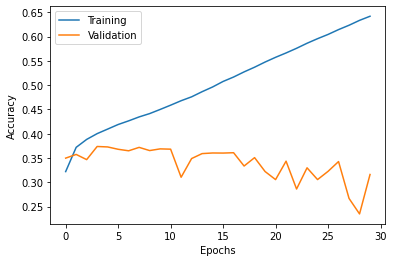

In [ ]:
plot_graphs(hist, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])

In [72]:
from keras.models import model_from_json

# load json and create model
json_file = open('model_v3.0.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_v3.0.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer='RMSprop', metrics=['sparse_categorical_accuracy'])
loaded_model.summary()

Loaded model from disk
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 300)      2213100     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 38, 512)      1140736     embedding[0][0]                  
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 2048)]       0                                            
________________________________________________________________

In [73]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

inception = InceptionV3(include_top=False,weights='imagenet',input_shape=(299,299,3),pooling='max')

img = "./flickr_data/Flickr_Data/Images/3767841911_6678052eb6.jpg"

test_img = get_encoding(inception, img)

In [74]:
word_index = tokenizer.word_index
key_list = list(word_index.keys()) 
val_list = list(word_index.values()) 
  
print(key_list[val_list.index(2)]) 

a


In [83]:
def beam_search_predictions(image_file, beam_index = 7):
    start = [word_index["startseq"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len - 1:
        temp = []
        for s in start_word:
            now_caps = sequence.pad_sequences([s[0]], maxlen=max_len - 1, padding='pre')
            preds = loaded_model.predict([np.array([image_file]), np.array(now_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top Beam index = 3  predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [key_list[val_list.index(i)] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

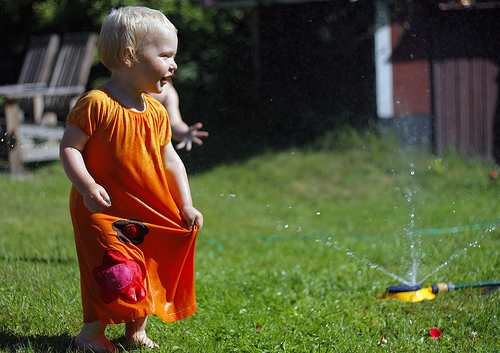

a little girl kicks a soccer ball on a grassy field


In [84]:
from IPython.display import Image, display
z = Image(filename=img)
display(z)

print(beam_search_predictions(test_img))

In [92]:
import os
from keras.preprocessing import image
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smoothie = SmoothingFunction().method4

def cal_blue():
  path = './flickr_data/Flickr_Data/Images/'
  blue_scores = []

  for img in tqdm(list(test_dataset.keys())[:500], position=0, leave=True):
    test_img_path = os.path.join(path, img)
    test_img = get_encoding(inception, test_img_path)
    caption = beam_search_predictions(test_img)

    true_cap = test_dataset[img][0]
    tmp_truecap = true_cap.split()
    tmp_predcap = caption.split()

    tmp_blue_score = sentence_bleu([tmp_truecap],tmp_predcap, weights=(1,0,0,0) ,smoothing_function=smoothie)
    
    blue_scores.append(tmp_blue_score)
  
  print('BLEU-I Score: ', mean(blue_scores))

cal_blue()

100%|██████████| 500/500 [1:36:53<00:00, 11.63s/it]

BLEU-I Score:  0.14507239313222114
